In [1]:
import os
import logging
from pathlib import Path

from dotenv import dotenv_values
import wandb
import numpy as np
import torch
import datasets
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from exrep.registry import load_hf_dataset, save_hf_dataset, load_model, load_tensor, get_artifact, save_tensor

if 'notebooks' in os.getcwd():
    os.chdir("../")

local_config = dotenv_values(".env")
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

random_state = 42

output_phase_name = "surrogate"

run = wandb.init(
    project=local_config["WANDB_PROJECT"],
    config={
        "job_type": "train_representation",
        "num_clusters": 40,
    },
    # reinit=True,
    # save_code=True,
)

device = "cuda:1"

wandb: Currently logged in as: nhathcmus to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [2]:
train_configs = {
    "target": dict(
        name='mocov3',
        variant='resnet50',
    ),
    "surrogate": dict(
        output_dim=256,
        use_key_encoder=False,
    ),
    "loss": dict(
        name="KDLossNaive",
        gamma1=1.0,
        gamma2=1.0,
        temp_student=0.05,
        temp_teacher=0.05,
    ),
    "optimizer": dict(
        lr=1e-2,
        weight_decay=1e-4,
    ),
}
run.config.update(train_configs)

In [3]:
%load_ext autoreload
%autoreload 2

from scripts.train_surrogate import train_surrogate_experiment

model, logs = train_surrogate_experiment(run, device=device, save=False)

/blue/thai/hoangx/projects/explain-representation/exrep/registry.py:218: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(file_path, map_location=map_locati

In [5]:
logs['val']

[{'epoch': 0,
  'step': 2,
  'val_grad_estimator': 4.864956378936768,
  'val_loss': 4.864956378936768,
  'val_accuracy': 0.004000000189989805},
 {'epoch': 1,
  'step': 4,
  'val_grad_estimator': 4.267549514770508,
  'val_loss': 4.267549514770508,
  'val_accuracy': 0.014000000432133675},
 {'epoch': 2,
  'step': 6,
  'val_grad_estimator': 4.002315998077393,
  'val_loss': 4.002315998077393,
  'val_accuracy': 0.02200000174343586},
 {'epoch': 3,
  'step': 8,
  'val_grad_estimator': 3.8407297134399414,
  'val_loss': 3.8407297134399414,
  'val_accuracy': 0.029000001028180122},
 {'epoch': 4,
  'step': 10,
  'val_grad_estimator': 3.732585906982422,
  'val_loss': 3.732585906982422,
  'val_accuracy': 0.021000001579523087},
 {'epoch': 5,
  'step': 12,
  'val_grad_estimator': 3.6620190143585205,
  'val_loss': 3.6620190143585205,
  'val_accuracy': 0.02200000174343586},
 {'epoch': 6,
  'step': 14,
  'val_grad_estimator': 3.612220287322998,
  'val_loss': 3.612220287322998,
  'val_accuracy': 0.03100000

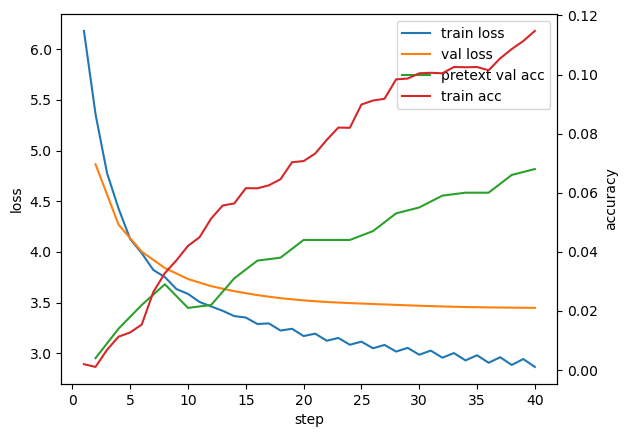

In [9]:
fig, ax = plt.subplots()

twin1 = ax.twinx()

p1, = ax.plot([log["step"] for log in logs["train"]], [log["loss"] for log in logs["train"]], 'C0', label="train loss")
p2, = ax.plot([log["step"] for log in logs["val"]], [log["val_loss"] for log in logs["val"]], 'C1', label="val loss")
p3, = twin1.plot([log["step"] for log in logs["val"]], [log["val_accuracy"] for log in logs["val"]], 'C2', label="pretext val acc")
p4, = twin1.plot([log["step"] for log in logs["train"]], [log["accuracy"] for log in logs["train"]], 'C3', label="train acc")

ax.set_ylabel("loss")
ax.set_xlabel("step")
# ax.set_ylim([0, 1])
twin1.set_ylabel("accuracy")
ax.legend(handles=[p1, p2, p3, p4])

In [4]:
from operator import itemgetter
from scripts.train_surrogate import load_data_from_runs
from exrep.model import init_target
from exrep.loss import init_loss

loss_fn = init_loss(**run.config.loss)

train_dataloader, val_dataloader, data_sizes = load_data_from_runs(run, batch_size=512, device=device)
samples_batch = next(iter(val_dataloader))
batch_features, batch_images, labels, _ = itemgetter("inputs", "image", "label", "indices")(samples_batch)
batch_features = batch_features.to(device)
batch_images = batch_images.to(device)

target_model = init_target(**run.config.target, device=device)

with torch.inference_mode():
    queries_teacher, keys_teacher, key_embeddings = target_model.self_sim(batch_images)
    # queries_student, keys_student = model(batch_features, key_embeddings)

wandb: Downloading large artifact imagenet-1k-first-20-take-2000_images:latest, 367.90MB. 7 files... 
wandb:   7 of 7 files downloaded.  
Done. 0:0:0.5


In [10]:
queries_student = torch.nn.functional.normalize(queries_student, dim=-1)
keys_student = torch.nn.functional.normalize(keys_student, dim=-1)
queries_teacher = torch.nn.functional.normalize(queries_teacher, dim=-1)
keys_teacher = torch.nn.functional.normalize(keys_teacher, dim=-1)

In [13]:
queries_student

tensor([[ 0.1655,  0.1197,  0.1091,  ..., -0.3600, -0.0136,  0.0662],
        [ 0.1305, -0.2111,  0.0485,  ..., -0.0447,  0.1439, -0.1244],
        [-0.2504,  0.0897, -0.2628,  ..., -0.0293, -0.2342,  0.2432],
        ...,
        [ 0.2058, -0.0485,  0.2424,  ..., -0.3885,  0.2390,  0.0015],
        [ 0.2487, -0.1362,  0.1345,  ..., -0.0621, -0.1517, -0.1440],
        [ 0.3313, -0.1133,  0.0745,  ..., -0.0063,  0.2246,  0.2170]],
       device='cuda:1')

In [14]:
keys_student

tensor([[ 0.2869, -0.2357,  0.0900,  ..., -0.2049,  0.0948,  0.0375],
        [ 0.0360, -0.3155,  0.1873,  ..., -0.2025,  0.0757,  0.0881],
        [ 0.0886, -0.2707,  0.2708,  ..., -0.2062,  0.0919,  0.0714],
        ...,
        [ 0.2832, -0.2101,  0.0973,  ..., -0.1697,  0.1804,  0.0500],
        [ 0.2454, -0.1816,  0.2636,  ..., -0.2056,  0.0910, -0.0445],
        [ 0.2977, -0.2528,  0.2425,  ..., -0.2208,  0.1716,  0.0836]],
       device='cuda:1')

In [15]:
torch.round(torch.softmax(queries_student @ keys_student.T / 0.1, dim=1), decimals=3)

tensor([[0.0060, 0.0040, 0.0020,  ..., 0.0010, 0.0010, 0.0020],
        [0.0150, 0.0090, 0.0050,  ..., 0.0010, 0.0060, 0.0050],
        [0.0000, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0000],
        ...,
        [0.0020, 0.0040, 0.0040,  ..., 0.0100, 0.0020, 0.0020],
        [0.0050, 0.0030, 0.0020,  ..., 0.0030, 0.0120, 0.0030],
        [0.0090, 0.0010, 0.0030,  ..., 0.0020, 0.0040, 0.0170]],
       device='cuda:1')

In [17]:
((queries_student @ keys_student.T).argmax(dim=1) == torch.arange(0, 512).to(device)).sum()

tensor(41, device='cuda:1')

In [18]:
x = batch_images

In [21]:
with torch.no_grad():
    h = target_model.base_encoder(x)
    x_proj = target_model.projector(h)
    z = target_model.predictor(x_proj)

In [24]:
(torch.softmax(loss_fn.get_scaled_sim(z, h_momen, 1), dim=1).argmax(dim=1).cpu() == torch.arange(0, 512)).sum()

tensor(512)

In [26]:
torch.nn.functional.cross_entropy(
    loss_fn.get_scaled_sim(z, h_momen, 1),
    torch.arange(0, 512).to(device),
)

tensor(5.3800, device='cuda:1')

In [23]:
with torch.no_grad():
    h_momen = target_model.model.momentum_encoder(x)

In [16]:
h_momen

tensor([[ 1.0539, -0.0286,  0.9931,  ..., -0.0202,  0.4289,  0.1627],
        [ 1.2701, -0.2168,  0.3956,  ..., -0.2498, -0.0049,  0.8681],
        [-0.2078,  0.2631,  0.2922,  ..., -1.2634, -0.1340,  0.3664],
        ...,
        [ 1.8823, -1.0362, -1.8931,  ..., -2.3653, -0.3285,  1.4250],
        [-0.2584,  0.1912, -0.1231,  ...,  0.3235,  0.5287,  0.8251],
        [-0.7633,  0.5527,  0.2063,  ..., -1.7018,  0.8414, -0.3228]],
       device='cuda:1')

In [22]:
torch.diagonal(torch.round(torch.softmax(queries_teacher @ keys_teacher.T / 0.05, dim=1), decimals=3)).mean()

tensor(0.7366, device='cuda:1')

In [33]:
torch.nn.functional.kl_div(
    torch.nn.functional.log_softmax(queries_student @ keys_student.T / 0.2, dim=1),
    torch.nn.functional.log_softmax(queries_teacher @ keys_teacher.T / 0.2, dim=1),
    reduction='batchmean',
    log_target=True,
)

tensor(0.4298, device='cuda:1')

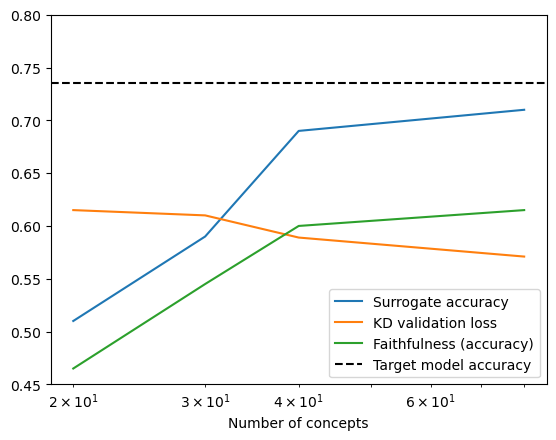

In [98]:
import matplotlib.pyplot as plt

x = [20, 30, 40, 80]
y1 = [0.51, 0.59, 0.69, 0.71]
y2 = [0.615, 0.61, 0.589, 0.571]
y3 = [0.465, 0.545, 0.6, 0.615]

fig, ax = plt.subplots()
ax.plot(x, y1, label="Surrogate accuracy")
ax.plot(x, y2, label="KD validation loss")
ax.plot(x, y3, label="Faithfulness (accuracy)")
ax.set_xlabel("Number of concepts")
plt.axhline(y=0.735, linestyle="--", color="black", label="Target model accuracy")
ax.set_ybound(0.45, 0.8)
# set x log scale
ax.set_xscale('log')
ax.legend()

plt.show()